### Downloading Dataset 📥

Este bloco de código realiza o download do conjunto de dados de imagens de células sanguíneas da plataforma Kaggle. Ele monta o Google Drive, configura a


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp "/content/drive/MyDrive/Kaggle API/kaggle.json" ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d unclesamulus/blood-cells-image-dataset

 99% 265M/268M [00:08<00:00, 32.9MB/s]
100% 268M/268M [00:08<00:00, 32.0MB/s]


In [ ]:
!unzip -qq "/content/blood-cells-image-dataset.zip"

### Visualização dos Dados 📊

Nesta seção, realizamos visualizações dos dados para entender melhor a distribuição e a aparência das imagens de células sanguíneas em nosso conjunto de dados. Utilizamos bibliotecas como Matplotlib, Seaborn e TensorFlow para visualizar e explorar as imagens.


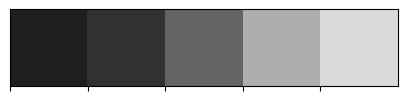

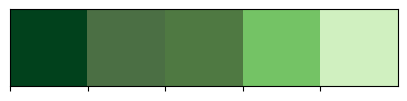

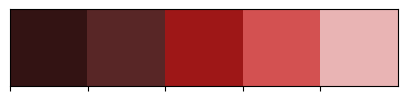

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
root_dir = '/content/bloodcells_dataset'

print("-- Labels --")
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    print(class_name)

-- Labels --
lymphocyte
monocyte
neutrophil
platelet
basophil
erythroblast
ig
eosinophil


In [ ]:
labels = { 'monocyte',
            'ig',
            'neutrophil',
            'basophil',
            'lymphocyte',
            'erythroblast',
            'eosinophil',
            'platelet' }

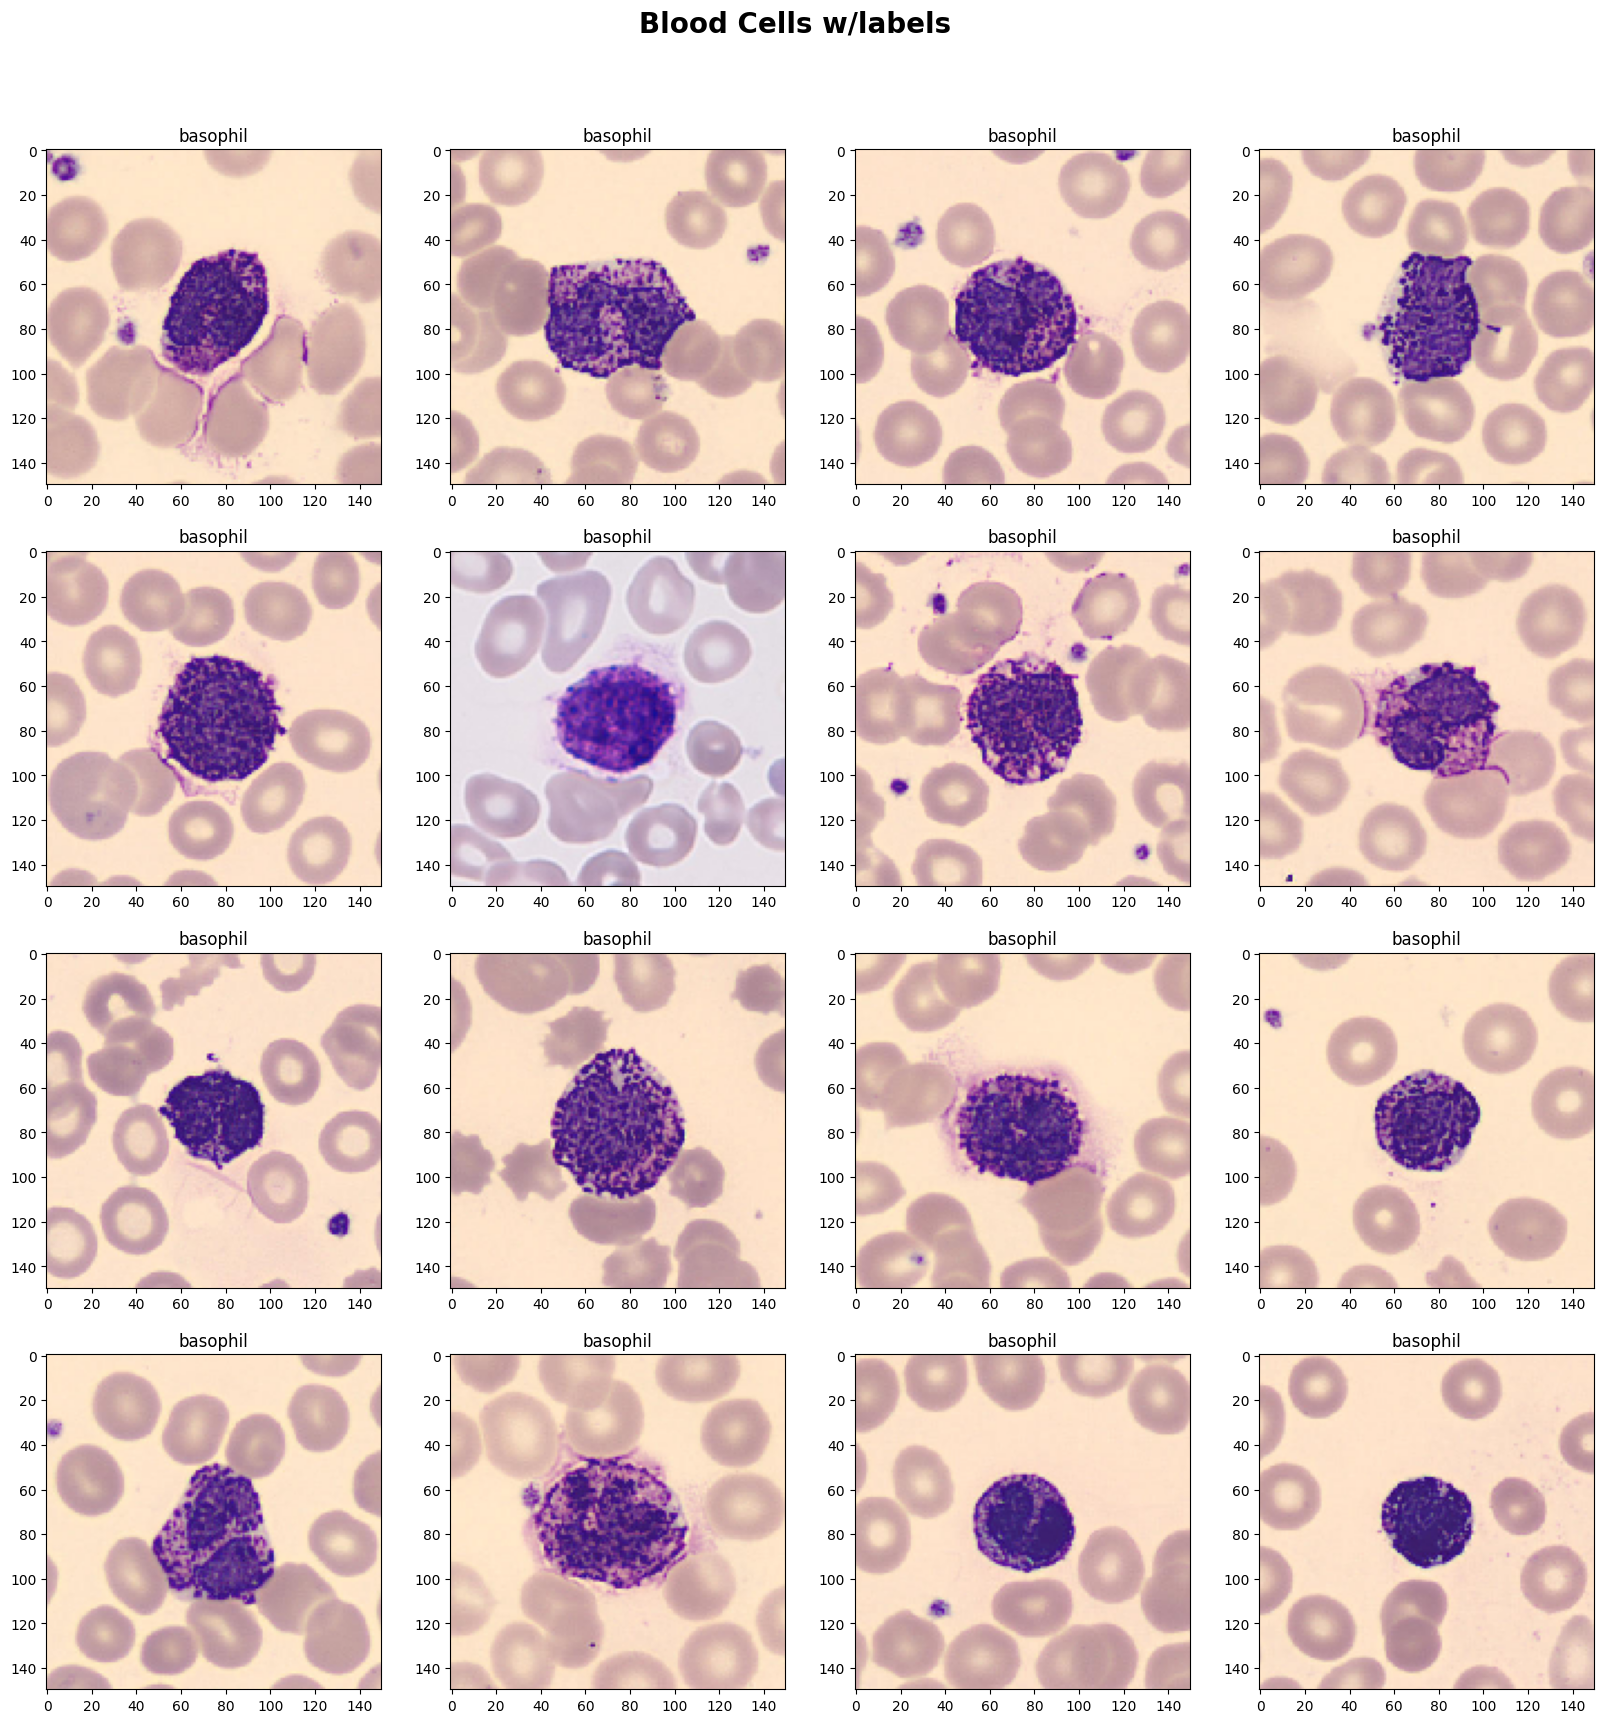

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

class_names = sorted(os.listdir(root_dir))

image_paths = []
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    image_names = os.listdir(class_dir)
    for image_name in image_names:
        image_path = os.path.join(class_dir, image_name)
        image_paths.append(image_path)

plt.figure(figsize=(20, 20))
plt.suptitle('Blood Cells w/labels', color='black', fontsize=20, fontweight='bold', x=0.5, y=0.95, ha='center', va='top')
for i in range(16):
    img = image.load_img(image_paths[i], target_size=(150, 150))
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    label = os.path.basename(os.path.dirname(image_paths[i]))
    plt.title("{}".format(label), color='black', fontsize=12)
    plt.axis('on')
plt.show()


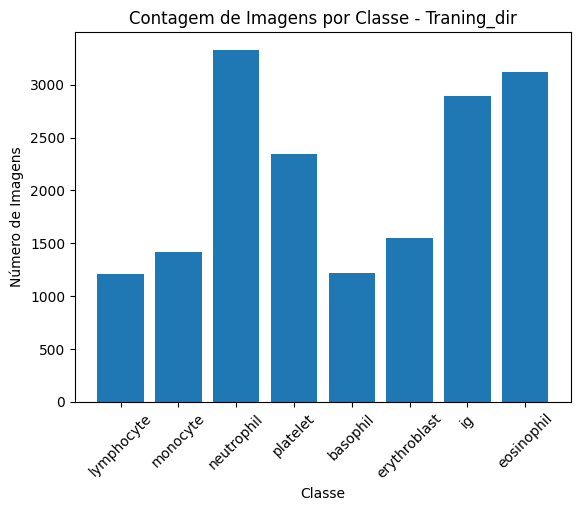

In [ ]:
import os
import matplotlib.pyplot as plt

data_dir =  root_dir

class_counts = {}
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images

plt.bar(range(len(class_counts)), list(class_counts.values()), tick_label=list(class_counts.keys()))
plt.xlabel('Classe')
plt.ylabel('Número de Imagens')
plt.title('Contagem de Imagens por Classe - Traning_dir')
plt.xticks(rotation=45)
plt.show()





### Pré-processamento das Imagens 🖼️

Nesta etapa, aplicamos várias etapas de pré-processamento às imagens de células sanguíneas antes de alimentá-las ao modelo de aprendizado. Utilizamos a função `image_dataset_from_directory` do TensorFlow para criar conjuntos de dados diretamente do diretório, facilitando a organização e divisão dos dados.

Para garantir uma entrada consistente para o modelo, todas as imagens são redimensionadas para o tamanho 224x224 pixels. Além disso, as classes são codificadas no formato one-hot encoding usando `label_mode="categorical"`.
(https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

Após a divisão inicial dos dados em conjuntos de treinamento, validação e teste (80%, 10% e 10% respectivamente), utilizamos métodos como `skip` e `take` para criar subconjuntos dos dados de treinamento, garantindo que tanto o conjunto de treinamento quanto o de validação sejam representativos da distribuição original dos dados.

Finalmente, verificamos a forma dos lotes de dados para confirmar que estão em conformidade com as expectativas do modelo. Isso inclui garantir que as dimensões das imagens e seus respectivos rótulos correspondam ao esperado, garantindo assim uma entrada correta para o modelo de aprendizado.







In [ ]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    image_size=(224, 224),
    validation_split=0.2,
    subset='both',
    label_mode="categorical",
    seed=42,
    batch_size=32,
    shuffle=True
)


Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.


In [ ]:
num_elements = len(train_ds)
train_size = int(0.8 * num_elements)
val_dataset = train_ds.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_ds.take(train_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(train_dataset), len(val_dataset), len(test_ds)

(342, 86, 107)

In [ ]:
 for data_batch, labels_batch in train_ds.take(1):
    print("Shape do lote de dados de treinamento:", data_batch.shape)
    print(f"Train labels: {labels_batch.shape}")

for data_batch, labels_batch in val_dataset.take(1):
    print("Shape do lote de dados de validacao:", data_batch.shape)
    print(f"Train labels: {labels_batch.shape}")

for data_batch, labels_batch in test_ds.take(1):
    print("Shape do lote de dados de teste:", data_batch.shape)
    print(f"Train labels: {labels_batch.shape}")


Shape do lote de dados de treinamento: (32, 224, 224, 3)
Train labels: (32, 8)
Shape do lote de dados de validacao: (32, 224, 224, 3)
Train labels: (32, 8)
Shape do lote de dados de teste: (32, 224, 224, 3)
Train labels: (32, 8)


### Construção do Modelo 🧠

Nesta seção, descrevemos a arquitetura e a configuração do modelo de classificação de células sanguíneas, uma etapa crítica na análise de imagens médicas. Optamos por utilizar a arquitetura ResNet50, uma rede neural convolucional (CNN) profundamente convolucional, conhecida por sua capacidade de extrair características complexas e hierárquicas de imagens.

A ResNet50 é composta por 50 camadas, incluindo camadas de convolução, ativação e pooling, com conexões residuais que ajudam a mitigar o problema de desaparecimento de gradientes, permitindo um treinamento mais eficaz de redes profundas.

Ao carregar a ResNet50, excluímos a camada superior (fully connected) da rede, pois estamos interessados apenas nas características extraídas pelas camadas convolucionais. Em seguida, congelamos todos os pesos da ResNet50 para evitar que sejam atualizados durante o treinamento subsequente. Isso é crucial para preservar as representações aprendidas durante o treinamento prévio na tarefa de classificação de imagens.

Para adaptar a ResNet50 ao nosso problema específico de classificação de oito classes (monócitos, linfócitos, neutrófilos, eosinófilos, basófilos, eritroblastos, plaquetas e IG), adicionamos camadas adicionais ao modelo. Uma camada de pooling global média é aplicada para consolidar as características espaciais em um vetor de características unidimensional.

Além disso, aplicamos uma camada de dropout com uma taxa de 20% para regularizar o modelo e reduzir o overfitting durante o treinamento. Por fim, uma camada densa com função de ativação softmax é adicionada para gerar as probabilidades de cada classe, permitindo a classificação final das imagens.

O resumo detalhado do modelo, exibindo o número de parâmetros treináveis e não treináveis em cada camada, é apresentado abaixo para uma melhor compreensão da estrutura do modelo e da complexidade do aprendizado.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [ ]:
feature_extraction_layer = ResNet50(include_top=False,
                                    input_shape=(224, 224, 3))

feature_extraction_layer.trainable = False


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model = feature_extraction_layer.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(8, activation='softmax')(model)
model = tf.keras.models.Model(inputs=feature_extraction_layer.input, outputs=model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Compilação do Modelo ⚙️

A compilação do modelo é uma etapa crítica no treinamento de redes neurais, onde definimos o algoritmo de otimização, a função de perda e as métricas de avaliação. Essas escolhas influenciam diretamente a capacidade do modelo de aprender padrões nos dados de treinamento e de generalizar para novos dados.

#### Função de Perda (Loss Function)

Para nosso problema de classificação de células sanguíneas em oito classes distintas, a função de perda `CategoricalCrossentropy` desempenha um papel fundamental. Essa função de perda calcula a entropia cruzada entre as distribuições de probabilidade verdadeiras e preditas, permitindo que o modelo avalie a discrepância entre suas previsões e os rótulos reais. Isso é essencial para garantir que o modelo aprenda a distinguir com precisão entre as diferentes classes de células sanguíneas. Por exemplo, ao prever uma célula sanguínea como um linfócito quando, na verdade, é um neutrófilo, a função de perda penaliza esse erro com base na confiança da previsão. Isso incentiva o modelo a ajustar seus pesos de forma a minimizar essa discrepância e aprimorar sua capacidade de classificação.

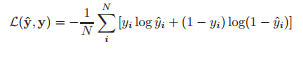

#### Otimizador (Optimizer)

O otimizador `Adam` é escolhido para ajustar os pesos do modelo durante o treinamento. Sua capacidade de adaptar a taxa de aprendizado de forma dinâmica com base nas estatísticas dos gradientes torna-o uma escolha eficaz para problemas complexos de otimização como o nosso. No contexto da classificação de células sanguíneas, onde o conjunto de dados pode ser grande e variado, é crucial que o otimizador seja capaz de ajustar eficientemente os pesos do modelo para encontrar mínimos locais de maneira rápida e eficaz. Isso ajuda a garantir que o modelo seja treinado de forma eficiente, maximizando sua capacidade de generalização para novos dados e melhorando sua precisão na classificação das diferentes classes de células sanguíneas.

Em resumo, a escolha cuidadosa da função de perda e do otimizador na compilação do modelo desempenha um papel fundamental em nosso problema de classificação de células sanguíneas. Esses elementos garantem que nosso modelo seja treinado de maneira eficaz, aprendendo a distinguir com precisão entre as diferentes classes de células sanguíneas e fornecendo resultados confiáveis e úteis para aplicações médicas e diagnósticos clínicos.


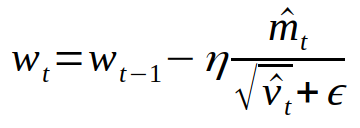

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


### Callbacks durante o Treinamento 🛠️

Durante o treinamento do modelo de classificação de células sanguíneas, é crucial monitorar o desempenho do modelo e tomar medidas para garantir um treinamento eficaz e eficiente. Nesta seção, definimos e configuramos vários callbacks do Keras para automatizar algumas dessas tarefas.

#### ModelCheckpoint

O callback `ModelCheckpoint` é utilizado para salvar o modelo com o melhor desempenho de validação durante o treinamento. Isso é útil para evitar a perda de progresso em caso de interrupção do treinamento ou para recuperar o melhor modelo para fins de inferência posterior. O modelo é salvo em um arquivo especificado pelo caminho `checkpoint_path` sempre que uma nova melhor precisão de validação é alcançada.

#### EarlyStopping

O callback `EarlyStopping` monitora uma métrica de validação (neste caso, a perda) e interrompe o treinamento se não houver melhoria após um determinado número de épocas (`patience`). Isso ajuda a evitar o sobreajuste do modelo, interrompendo o treinamento assim que o desempenho na validação começa a piorar. Os pesos do modelo são então restaurados para os melhores encontrados durante o treinamento.

#### ReduceLROnPlateau

O callback `ReduceLROnPlateau` ajusta dinamicamente a taxa de aprendizado do otimizador durante o treinamento com base no desempenho da validação. Se a precisão de validação não melhorar por um número específico de épocas (`patience`), a taxa de aprendizado é reduzida por um fator específico (`factor`). Isso ajuda a melhorar a convergência do modelo e a estabilidade do treinamento.

Esses callbacks são fundamentais para garantir um treinamento suave e eficaz do modelo, ajudando a evitar o sobreajuste, a salvar os melhores modelos e a ajustar dinamicamente a taxa de aprendizado durante o processo de treinamento.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/Model/best_model.h5"


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

### Treinamento do Modelo 🚀

Nesta seção, iniciamos o treinamento do modelo de classificação de células sanguíneas utilizando o conjunto de dados de treinamento e validação preparados anteriormente. Utilizamos o método `fit` do Keras para ajustar o modelo aos dados de treinamento, enquanto monitoramos o desempenho na validação e aplicamos callbacks para automatizar tarefas importantes durante o treinamento.

#### Método de Ajuste (fit)

O método `fit` é utilizado para treinar o modelo com os dados de treinamento. Durante o treinamento, o modelo é ajustado aos dados de entrada e otimizado para minimizar a função de perda especificada. Neste caso, definimos um total de 40 épocas (`epochs`) para treinamento.

#### Conjunto de Dados de Treinamento e Validação

Utilizamos o conjunto de dados de treinamento (`train_dataset`) para treinar o modelo e o conjunto de dados de validação (`val_dataset`) para avaliar o desempenho do modelo em dados não vistos durante o treinamento. Isso nos permite monitorar o progresso do modelo e detectar possíveis problemas de sobreajuste ou subajuste.

#### Callbacks durante o Treinamento

Durante o treinamento, aplicamos dois callbacks importantes: `checkpoint_callback` e `reduce_lr`. O `checkpoint_callback` salva o modelo com o melhor desempenho de validação, enquanto o `reduce_lr` ajusta dinamicamente a taxa de aprendizado do otimizador com base no desempenho da validação. Esses callbacks ajudam a garantir um treinamento suave e eficaz do modelo, evitando o sobreajuste e ajustando a taxa de aprendizado conforme necessário.

O histórico do treinamento, incluindo as métricas de perda e precisão em cada época, será registrado para análise e visualização posterior.


In [ ]:
history = model.fit(
      train_dataset,
      epochs=40,
      validation_data=val_dataset,
      callbacks=[checkpoint_callback, reduce_lr])

Epoch 1/40
341/342 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.9071
Epoch 1: val_accuracy improved from -inf to 0.91941, saving model to /content/Model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


342/342 [==============================] - 33s 97ms/step - loss: 0.2836 - accuracy: 0.9071 - val_loss: 0.2572 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 2/40
342/342 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9118
Epoch 2: val_accuracy improved from 0.91941 to 0.92747, saving model to /content/Model/best_model.h5
342/342 [==============================] - 35s 102ms/step - loss: 0.2736 - accuracy: 0.9118 - val_loss: 0.2291 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 3/40
341/342 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.9161
Epoch 3: val_accuracy improved from 0.92747 to 0.92894, saving model to /content/Model/best_model.h5
342/342 [==============================] - 38s 111ms/step - loss: 0.2647 - accuracy: 0.9158 - val_loss: 0.2245 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 4/40
341/342 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9199
Epoch 4: val_accuracy did not improve from 0.92894
342/342 [==========

### Avaliação do Modelo 📊

Após o treinamento do modelo de classificação de células sanguíneas, é fundamental avaliar seu desempenho para entender sua capacidade de generalização e identificar possíveis áreas de melhoria. Nesta seção, realizamos uma análise abrangente do desempenho do modelo utilizando diversas métricas e visualizações.

#### Gráficos de Precisão e Perda ao Longo das Épocas

Iniciamos analisando a evolução da precisão e da perda do modelo ao longo do treinamento, tanto nos dados de treinamento quanto nos dados de validação. Os gráficos mostram como essas métricas evoluíram ao longo das épocas, fornecendo insights sobre o desempenho e a convergência do modelo durante o treinamento.

#### Matriz de Confusão

Em seguida, examinamos a matriz de confusão, que nos permite entender como o modelo está classificando as diferentes classes de células sanguíneas. A matriz mostra a contagem de predições corretas e incorretas para cada classe, ajudando a identificar padrões de erros e áreas de confusão do modelo.

#### Área Sob a Curva ROC (ROC AUC)

Calculamos a área sob a curva ROC (ROC AUC), uma métrica que quantifica o desempenho global do modelo em todas as classes. Uma pontuação ROC AUC de 1 indica um modelo perfeito, enquanto uma pontuação próxima a 0.5 indica um desempenho aleatório. Esta métrica nos fornece uma visão geral do quão bem o modelo está discriminando entre as diferentes classes de células sanguíneas.

#### Dicionário de Rótulos das Classes

Por fim, exibimos um dicionário que mapeia os índices das classes para seus rótulos correspondentes. Isso nos ajuda a interpretar as saídas do modelo e entender a correspondência entre os índices e as classes reais de células sanguíneas.

Essa análise abrangente nos fornece uma compreensão profunda do desempenho do modelo de classificação de células sanguíneas, permitindo-nos tomar decisões informadas sobre ajustes e melhorias futuras.


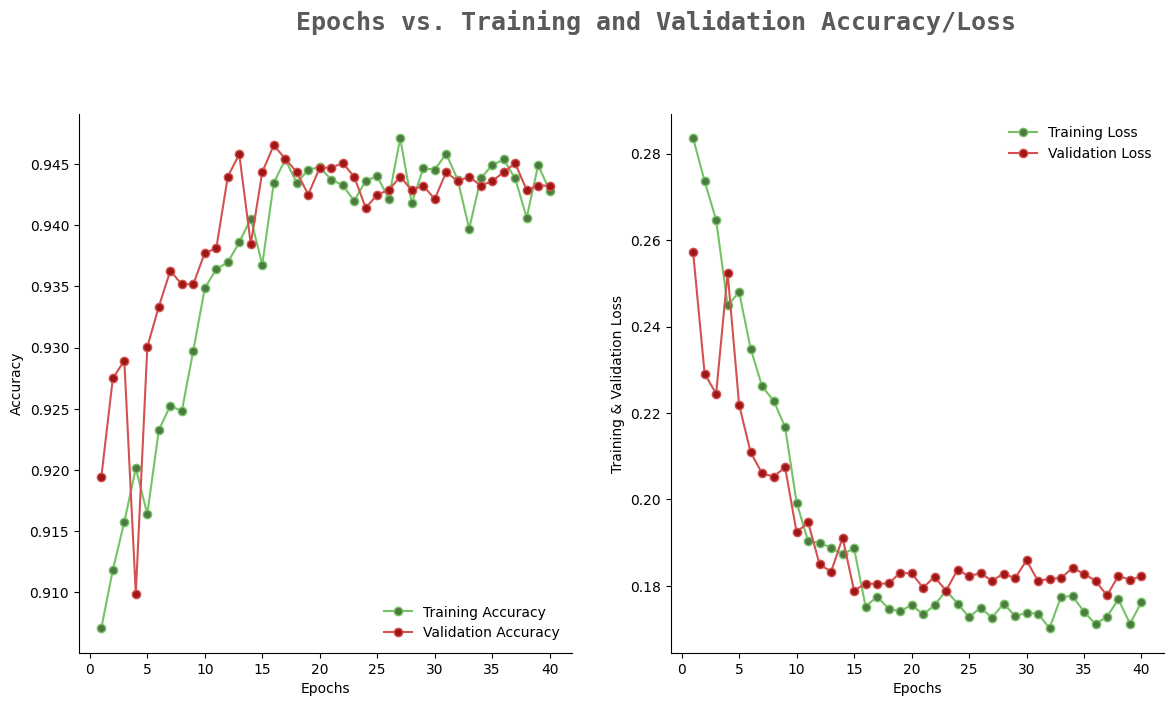

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suprimindo os avisos
filterwarnings('ignore')

# Obtendo os dados do histórico de treinamento
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Criando uma lista de épocas
epochs = range(1, len(train_acc) + 1)

# Criando a figura e os eixos
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Configurando o título da figura
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

# Configurando o estilo dos plots
sns.despine()

# Plotando a precisão de treinamento e validação
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Plotando a perda de treinamento e validação
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

# Mostrando a figura
plt.show()


107/107 [==============================] - 7s 62ms/step


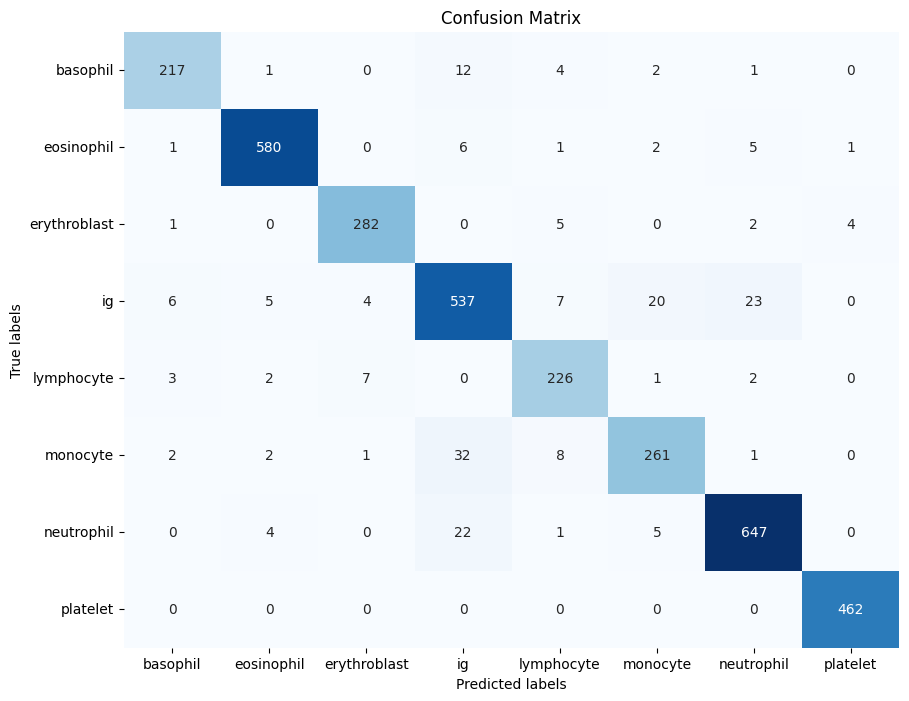

ROC AUC Score: 0.9966354660613662
Label Dictionary:
{0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3: 'ig', 4: 'lymphocyte', 5: 'monocyte', 6: 'neutrophil', 7: 'platelet'}


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Função para obter os rótulos das classes a partir do dataset
def get_class_labels(dataset):
    class_names = dataset.class_names
    return class_names

# Previsões do modelo nos dados de teste
predictions = model.predict(test_ds)
# Convertendo previsões em classes (índices do máximo)
predicted_classes = np.argmax(predictions, axis=1)

# Rótulos verdadeiros dos dados de teste
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Convertendo one-hot encoding dos rótulos verdadeiros para classes
true_labels_classes = np.argmax(true_labels, axis=1)

# Obtendo os rótulos das classes a partir do dataset
class_labels = get_class_labels(test_ds)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(true_labels_classes, predicted_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculando a área sob a curva ROC (ROC AUC)
roc_auc = roc_auc_score(true_labels_classes, predictions, multi_class='ovr')

print("ROC AUC Score:", roc_auc)


# Criando um dicionário de rótulos das classes
label_dict = {i: label for i, label in enumerate(class_labels)}

# Exibindo o dicionário de rótulos das classes
print("Label Dictionary:")
print(label_dict)
